In [29]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [14]:
df = pd.read_csv('imdb-reviews-pt-br.csv')
M = df.to_numpy()
#print(M)

#matriz com colunas de reviews em pt

M_pt_br = M[:, 2]
#print(M_pt_br)

In [15]:
#download de palavras desnecessárias para nosso embedding (o,a, os, as, de, ...) stopwords. (como mostrado no print(stop_pt))
nltk.download('stopwords')

stop_pt = stopwords.words('portuguese')
print(stop_pt)

['a', 'à', 'ao', 'aos', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aquilo', 'as', 'às', 'até', 'com', 'como', 'da', 'das', 'de', 'dela', 'delas', 'dele', 'deles', 'depois', 'do', 'dos', 'e', 'é', 'ela', 'elas', 'ele', 'eles', 'em', 'entre', 'era', 'eram', 'éramos', 'essa', 'essas', 'esse', 'esses', 'esta', 'está', 'estamos', 'estão', 'estar', 'estas', 'estava', 'estavam', 'estávamos', 'este', 'esteja', 'estejam', 'estejamos', 'estes', 'esteve', 'estive', 'estivemos', 'estiver', 'estivera', 'estiveram', 'estivéramos', 'estiverem', 'estivermos', 'estivesse', 'estivessem', 'estivéssemos', 'estou', 'eu', 'foi', 'fomos', 'for', 'fora', 'foram', 'fôramos', 'forem', 'formos', 'fosse', 'fossem', 'fôssemos', 'fui', 'há', 'haja', 'hajam', 'hajamos', 'hão', 'havemos', 'haver', 'hei', 'houve', 'houvemos', 'houver', 'houvera', 'houverá', 'houveram', 'houvéramos', 'houverão', 'houverei', 'houverem', 'houveremos', 'houveria', 'houveriam', 'houveríamos', 'houvermos', 'houvesse', 'houvessem', 'houvésse

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\guede\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Aqui, usamos o processo de TF-IDF para converter os textos em vetores numéricos e com isso, geramos uma matriz esparsa com todos esses vetores.
# OBS fiz alguns testes com 10k e 5k e perdi apenas 1 % de acuracia no modelo 

vectorizer = TfidfVectorizer(max_features=3000, stop_words=stop_pt,)
M_tf_idf = vectorizer.fit_transform(M_pt_br)

#print(X)


In [ ]:
#teste da matriz esparsa
vocab = vectorizer.get_feature_names_out()
print(vocab)

['000' '10' '100' ... 'únicas' 'único' 'únicos']


In [ ]:
# transformação para formato denso para fazer logo em seguida PCA
# (para plotar um grafico mostrando visualmente onde cada palavra esta) 
# e SVD para capturar as principais palavras do nosso dataset

M_denso = M_tf_idf.toarray()

print(M_denso)

[[0.         0.         0.         ... 0.         0.11454747 0.        ]
 [0.         0.06550199 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.18032027 0.13837524]
 ...
 [0.         0.05019978 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [19]:
pca = PCA(2)
pca_M = pca.fit_transform(M_denso)

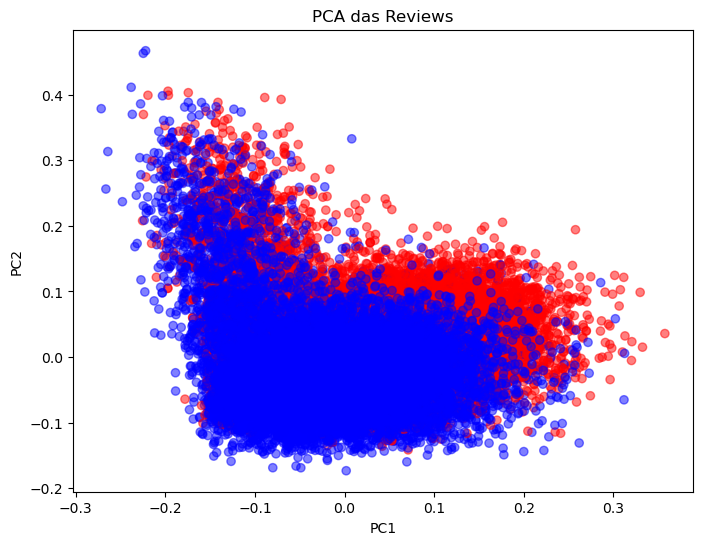

In [28]:
avaliacao = df.iloc[:,3].values
cores = ['blue' if s == 'pos' else 'red' for s in avaliacao]

plt.figure(figsize=(8,6))
plt.scatter(pca_M[:,0], pca_M[:,1], c = cores, alpha=0.5)
plt.title("PCA das Reviews")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [ ]:
#Fazendo SVD

# 1. Centralizar os dados (Média zero por coluna)
M_centralizado = M_denso - np.mean(M_denso, axis=0)
# U: Vetores singulares a esquerda
# S: Valores singulares
# Vt: Vetores singulares a direita

U, S, Vt = np.linalg.svd(M_centralizado, full_matrices=False)

# 3. Projetar nos 2 primeiros componentes principais (k=2)
# Pelo Teorema de Eckart-Young (T25), isso é a melhor aproximação de posto 2.
k = 50
M_reduzido = U[:, :k] * S[:k]

Para manter 85.0% da informação original, precisamos de k = 1921 dimensões.
47048.011399208175


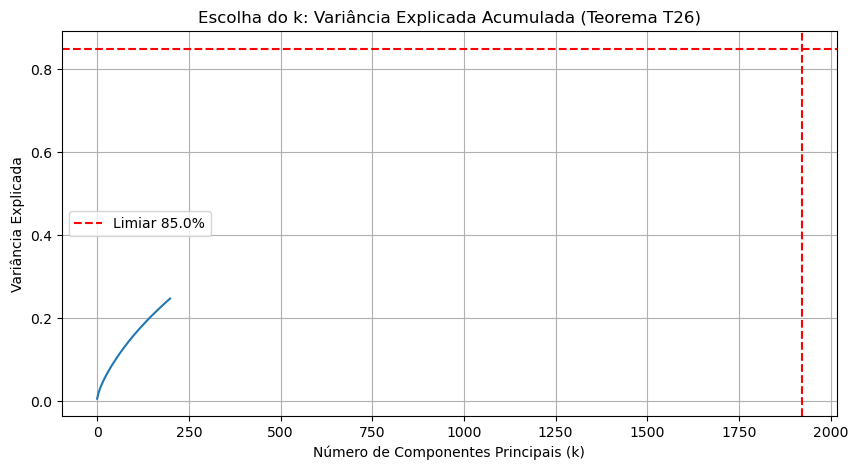

In [ ]:

# soma dos quadrados dos valores singulares (energia)

energia_total = np.sum(S**2)

# 2. Calcular a Energia Acumulada
# Quanto de informação mantemos ao adicionar cada nova dimensão?
energia_acumulada = np.cumsum(S**2) / energia_total

# 3. Definir um limiar (Ex: manter 85% da informação)
limiar = 0.85
k_ideal = np.argmax(energia_acumulada >= limiar) + 1


print(f"Para manter {limiar*100}% da informação original, precisamos de k = {k_ideal} dimensões.")
# 4. Plotar o Gráfico de "Cotovelo" (Variância Explicada)
plt.figure(figsize=(10, 5))
plt.plot(energia_acumulada[:200]) # Plotando apenas os primeiros 200 para facilitar a visão
plt.axhline(y=limiar, color='r', linestyle='--', label=f'Limiar {limiar*100}%')
plt.axvline(x=k_ideal, color='r', linestyle='--')
plt.title('Escolha do k: Variância Explicada Acumulada (Teorema T26)')
plt.xlabel('Número de Componentes Principais (k)')
plt.ylabel('Variância Explicada')
plt.legend()
plt.grid()
plt.show()

In [39]:


# Projetando os dados de treino nessas 50 dimensões
X_projeto = U[:, :k] * S[:k]
y_projeto = df.iloc[:, -1].values # Seus rótulos

# Treinando a Regressão Logística nesses dados corretos
X_train, X_test, y_train, y_test = train_test_split(X_projeto, y_projeto, test_size=0.2, random_state=42)
modelo_final = LogisticRegression(solver='liblinear')
modelo_final.fit(X_train, y_train)

print(f"   Modelo treinado com 50 dimensões.")
print(f"   Acurácia no teste: {accuracy_score(y_test, modelo_final.predict(X_test)):.2%}")

# funcao de Previsão
def analisar_frase(texto_usuario):
    try:
        # 1. Vetorização (texto para números)
        vetor_tfidf = vectorizer.transform([texto_usuario]).toarray()
        media_colunas = np.mean(M_denso, axis=0)

        # 2. Centralização (Usando a média calculada em cima)
        vetor_centralizado = vetor_tfidf - media_colunas

        # 3. Projeção SVD (Números para 50 Números)

        # usamos o mesmo k e o 'Vt' calculado agora
        vetor_reduzido = np.dot(vetor_centralizado, Vt[:k].T)

        # 4. Classificação
        predicao = modelo_final.predict(vetor_reduzido)[0]
        probs = modelo_final.predict_proba(vetor_reduzido)[0]

        # Resultado
        cor = "\033[94m" if predicao == 'pos' else "\033[91m"

        reset = "\033[0m"
        print(f"\nTexto: \"{texto_usuario}\"")
        print(f"Classificação: {cor}{predicao.upper()}{reset} (Certeza: {max(probs):.2%})")

    except Exception as e:
        print(f"Erro: {e}")

# Teste
print("\n--- Testando ---")
analisar_frase("O filme é uma obra de arte, adorei cada segundo!")
analisar_frase("Péssimo, perdi meu tempo. O roteiro é horrível")

   Modelo treinado com 50 dimensões.
   Acurácia no teste: 83.72%

--- Testando ---

Texto: "O filme é uma obra de arte, adorei cada segundo!"
Classificação: POS (Certeza: 93.88%)

Texto: "Péssimo, perdi meu tempo. O roteiro é horrível"
Classificação: NEG (Certeza: 99.94%)


In [38]:
analisar_frase("filme ruim")


Texto: "filme ruim"
Sentimento: NEG (Certeza: 100.00%)
